# Bootleneck V.4 (Análisis por día, hr Chile continental -04:00:00)

Después de haber entregado el análisis preliminar al cliente, en donde encontramos los valores del __flujo promedio limpio__ (en camiones por hora) para cada zona operacional, es momento de dar un vuelco y comenzar a procesar los datos conforme a encontrar patrones o indicadores de cuellos de botella dentro de CS. Para ello tomaremos la siguiente estructura.

1. Estructuración de los datos.
2. Calculo de estadísticos
3. Representación de estos. 

---

Para entender mejor la estructuración de los datos es necesario comprender ciertos objetivos y conceptos.

__Objetivo Principal__: Comprender el funcionamiento de la faena CS a través del análisis de los tiempos de espera y atención para cada Zona Operacional (ZO)

__Estrategia__: Buscar información en bloques de 30 minutos.

Tendremos 3 tipos de estatus:
1. Atención: cuando un camión se encuentra dentro de una ZO
2. Espera: cuando un camión está en espera o tránsito a una ZO
3. Out: Cuando el camión se encuentra fuera de la faena CS

Qué pretendemos encontrar en cada bloque establecido, para Atención y Espera?
1. N° de camiones que ingresaron y salieron de una ZO
2. N° de camiones que estaban en una ZO al inicio del bloque.
3. Tiempo acumulado de atención (SUM_i (t_i) = Tiempo acumulado).
4. Promedio, moda, media, max, min de tiempos de atención
5. Promedio, moda, media, max, min en el conteo de vehículos en Espera y Atención.

__Conceptos importantes__

1. __Tiempos de IDLE__: cuando tenemos una ZO inactiva y sin camiones en espera
2. __Tiempos de inactividad__: cuando tenemos una ZO inactiva y con camiones en espera
3. __Tiempos de Transición__: corresponden a los tiempos de salida y llegada de camiones (se estima que el máximo debe ser 5 min).


---

# 1. Estructuración de los datos 

Tomaremos en consideración los filtros aplicados en la sección de preprocesado, sin embargo añadiremos nuevas columnas omitidas en ese análisis, como lo son las columnas de "ZO Pre-Time", "ZO start", "ZO end" y quizás otra que consideremos importante para estos propósitos. 

Además,no eliminamos los viajes que van desde CS a CS, es decir los camiones que se encuentran en la misma faena todo el tiempo, debido a que se puede que sean partícipes del cuello de botella generado.

En esta oportunidad no nos enfocaremos en rutas en particular, solamente en las fechas de cada evento. Para ello utilizaremos los tiempos dados por Zone Start y Zone End. Además, despreciaremos las columnas de hora de entrada, hora salida, año entrada, año salida.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import datetime
import seaborn as sns

In [2]:
df = pd.read_csv("BoottleNeck_filtered_v2.csv", engine='python')
df = df.drop("Unnamed: 0",axis=1)

cols = ['Year [Out]','Month [In]','Month [Out]','Day [In]','Day [Out]','Hour [In]','Hour [Out]']

#Convertimos Zone start y end en .time (hh:mm:ss)
for i in range(1,99):
    zone_1 = "Zone Start (%s)"%i
    zone_2 = "Zone End (%s)"%i
    df[zone_1] = pd.to_datetime(df[zone_1], utc = True).dt.tz_convert('Chile/Continental').dt.time
    df[zone_2] = pd.to_datetime(df[zone_2], utc = True).dt.tz_convert('Chile/Continental').dt.time
df["Date [In]"] = df['Year [In]'].astype(str) + "-" + df["Month [In]"].astype(str) + "-" + df["Day [In]"].astype(str)+" "+df['Hour [In]'].astype(str)+":00:00"
df["Date [In]"] = pd.to_datetime(df["Date [In]"],utc = True)
df["Date [Out]"] = df['Year [Out]'].astype(str) + "-" + df["Month [Out]"].astype(str) + "-" + df["Day [Out]"].astype(str)+" "+df['Hour [Out]'].astype(str)+":00:00"
df["Date [Out]"] = pd.to_datetime(df["Date [Out]"],utc = True)
#convertimos utc a Chile/Continental
df['Date [In]']=pd.to_datetime(df['Date [In]'], utc = True).dt.tz_convert('Chile/Continental')
df["Date [Out]"] = pd.to_datetime(df["Date [Out]"],utc = True).dt.tz_convert('Chile/Continental')

df['Day of year [In]']=pd.to_datetime(df['Date [In]']).dt.dayofyear
df['Day of year [Out]']=pd.to_datetime(df['Date [Out]']).dt.dayofyear

#Dejamos Date [In] como estaba
df["Date [In]"] = pd.to_datetime(df["Date [In]"]).dt.date
df["Date [Out]"] = pd.to_datetime(df["Date [Out]"]).dt.date
df=df.drop(cols,axis=1)
df

Cycle Id  Year [In]            Origin     Destination   Zone Name (1)  \
0      10242520       2019          Coya Sur       Tocopilla  Romana Salitre   
1      10242540       2019         Tocopilla        Coya Sur    C Secado L-4   
2      10527578       2019          Coya Sur        Coya Sur  Romana Salitre   
3       9250786       2019          Coya Sur  Nueva Victoria           C PTS   
4       8143041       2019          Coya Sur  Nueva Victoria          C NPT3   
...         ...        ...               ...             ...             ...   
95249  18633231       2020    Nueva Victoria        Coya Sur             NaN   
95250  18633167       2020          Coya Sur   Virtual_Place          C NPT3   
95251  18633133       2020    Nueva Victoria        Coya Sur             NaN   
95252  18633510       2020  Salar de Atacama        Coya Sur          C NPT3   
95253  18633550       2020  Salar de Atacama        Coya Sur          C NPT3   

       Zone Pre Time (1) Zone Start (1) Zone End (1)  Zone Time (1)  \
0                  249.0       11:30:58     11:35:06          248.0   
1                 5664.0       17:28:39     17:35:53          434.0   
2                    0.0       19:59:34     20:06:35          421.0   
3                    0.0       20:00:09     20:05:52          343.0   
4                  601.0       20:41:50     20:46:50          300.0   
...                  ...            ...          ...            ...   
95249                NaN            NaT          NaT            NaN   
95250              760.0       01:45:18     01:54:19          541.0   
95251                NaN            NaT          NaT            NaN   
95252              715.0       01:46:43     01:53:46          423.0   
95253             1175.0       01:55:39     02:01:05          326.0   

        Zone Name (2)  ...  Zone Time (97) Zone Name (98) Zone Pre Time (98)  \
0        C Secado L-4  ...             NaN            NaN                NaN   
1      Romana Salitre  ...             NaN            NaN                NaN   
2              Salida  ...             NaN            NaN                NaN   
3              Salida  ...             NaN            NaN                NaN   
4              Salida  ...             NaN            NaN                NaN   
...               ...  ...             ...            ...                ...   
95249             NaN  ...             NaN            NaN                NaN   
95250          Salida  ...             NaN            NaN                NaN   
95251             NaN  ...             NaN            NaN                NaN   
95252          Salida  ...             NaN            NaN                NaN   
95253          Salida  ...             NaN            NaN                NaN   

       Zone Start (98) Zone End (98)  Zone Time (98)   Date [In]  Date [Out]  \
0                  NaT           NaT             NaN  2019-06-30  2019-06-30   
1                  NaT           NaT             NaN  2019-06-30  2019-06-30   
2                  NaT           NaT             NaN  2019-06-30  2019-06-30   
3                  NaT           NaT             NaN  2019-06-30  2019-06-30   
4                  NaT           NaT             NaN  2019-06-30  2019-06-30   
...                ...           ...             ...         ...         ...   
95249              NaT           NaT             NaN  2020-06-08  2020-06-08   
95250              NaT           NaT             NaN  2020-06-08  2020-06-08   
95251              NaT           NaT             NaN  2020-06-08  2020-06-08   
95252              NaT           NaT             NaN  2020-06-08  2020-06-08   
95253              NaT           NaT             NaN  2020-06-08  2020-06-08   

       Day of year [In] Day of year [Out]  
0                   181               181  
1                   181               181  
2                   181               181  
3                   181               181  
4                   181               181  
...    

In [3]:
zonas = ['Romana Salitre', 'C Secado L-4', 'C PTS', 'C NPT3', 'Romana Mto', 'C ATM', 'C NPT 1-2', 'C Prilado', 'Losa Envasado', 'C CS-4',
 'C Secado L-3', 'C Granulacion', 'Galpones', 'C NPT4', 'C CS-12', 'C CS-P.Valdivia', 'Romana 3', 'C CS-11']
def block_generator(dia_inicio,dia_fin,inicio,fin,condition='in'):
    """Entregamos un Año, mes, día  y el rango de horas entre las cuales se quiere tener el bloque, 
       hr:min:seg > block >hr_:min_:seg_ """
    cont = 0
    for i in range(1,99):
        zone_1 = "Zone Name (%s)"%i
        zone_2 = "Zone Pre Time (%s)"%i
        zone_3 = "Zone Start (%s)"%i
        zone_4 = "Zone End (%s)"%i
        zone_5 = "Zone Time (%s)"%i

        cols=['Cycle Id', 'Origin', 'Destination','Date [In]','Date [Out]','Day of year [In]','Day of year [Out]',
              zone_1, zone_2, zone_3, zone_4, zone_5]

        date_lower = datetime.time(inicio[0], inicio[1], inicio[2])
        date_upper = datetime.time(fin[0], fin[1], fin[2])
        
        if (condition == 'in'):
            a = df[(df[zone_3] < date_upper) & (df[zone_3] >= date_lower) & (df['Day of year [In]'] >= dia_inicio) & (df['Day of year [In]'] <= dia_fin)] 
        elif (condition == 'out'):
            a = df[(df[zone_4] < date_upper) & (df[zone_4] >= date_lower) & (df['Day of year [Out]'] >= dia_inicio) & (df['Day of year [Out]'] <= dia_fin)]     
        else:
            break
        b = a.loc[:,cols]
        b = b.rename(columns={zone_1:"Name ZO",
                          zone_2:"Pre Time",
                          zone_3:"Start",
                          zone_4:"End",
                          zone_5:"Time"})    
        if cont == 0:
            block = b
            cont += 1
            continue
        else:
            block = pd.concat([block, b], axis=0, sort=False) 
    block = block.sort_values(['Cycle Id', 'Name ZO',"Date [In]"], ascending=[True,True,True])
    return block

#Vehiculos ingresados
def vehiculos(dia_inicio,dia_fin,inicio=1,fin=25,condition='in'):
    """Generamos un diccionario que contenga zona: {bloque hr: vehiculos ingresados} """
    diccionario = {}
    for i in range(inicio,fin):
        start = [i-1,0,0]
        if(i == 24):
            end = [23,59,59]
        else:
            end = [i,0,0]
        if (condition == 'out'):
            df_ = block_generator(dia_inicio,dia_fin,start,end,condition=condition)
            date_lower = datetime.time(start[0], start[1], start[2])
            date_upper = datetime.time(end[0], end[1], end[2])
        elif (condition == 'in'):
            df_ = block_generator(dia_inicio,dia_fin,start,end,condition=condition)
        else:
            break
        for zo in df_['Name ZO'].unique().tolist(): 
            block_filtered = df_[df_['Name ZO'] == zo]
            if (condition == 'out'):
                block_filtered = block_filtered[(block_filtered['End'] < date_upper) & (block_filtered['End'] >= date_lower)]
            vehiculos_in = block_filtered.shape[0]
            if zo == 'Salida':
                continue
            else:
                if zo in diccionario.keys():
                    diccionario[zo].update({i:vehiculos_in})
                else:
                    diccionario.update({zo:{i:vehiculos_in}})
    return diccionario

def vehiculos_time(dia_inicio,dia_fin,inicio=1,fin=25,condition='in',cond='time'):
    """Generamos un diccionario que contenga zona: {bloque hr: vehiculos salieron} """
    diccionario = {}
    for i in range(inicio,fin):
        start = [i-1,0,0]
        if(i == 24):
            end = [23,59,59]
        else:
            end = [i,0,0]
        df_ = block_generator(dia_inicio,dia_fin,start,end,condition=condition)
        date_lower = datetime.time(start[0], start[1], start[2])
        date_upper = datetime.time(end[0], end[1], end[2])
        for zo in df_['Name ZO'].unique().tolist(): 
            block_filtered = df_[df_['Name ZO'] == zo]
            block_filtered = block_filtered[(block_filtered['End'] < date_upper) & (block_filtered['End'] >= date_lower)]
            if(cond=='pre time'):
                cumulative_time = block_filtered['Pre Time'].sum()
            else:
                cumulative_time = block_filtered.Time.sum()
            if zo == 'Salida':
                continue
            else:
                if zo in diccionario.keys():
                    diccionario[zo].update({i:(cumulative_time/60)})
                else:
                     diccionario.update({zo:{i:(cumulative_time/60)}})                
    return diccionario

def dict_to_df(dictionary):
    """ Pasamos de Dicionario a df de la forma que nosotros necesitamos"""
    count=0
    for k, v in dictionary.items():
        a = pd.DataFrame.from_dict(v,'index')
        a = a.rename(columns={a.columns[0]:k})
        if (count == 0):
            b = a
            count +=1
            continue 
        else:
            b=pd.concat([b,a],axis=1)
    b = b.fillna(0)
    cols_b = b.keys().tolist()
    diff = list(set(zonas) - set(cols_b))
    #print(b)
    #print(diff)
    if (len(diff) > 0):
        for i in diff:
            #print(i)
            b[i] = 0
    b = b.reindex(sorted(b.columns), axis=1)
    #print(b)
    return b



# Analisis por maximos.

Por cada día dentro del mes realizaremos la generación de un data frame nuevo que contenga los maximos de esos 2 dataframes en cuestion.

In [14]:
dias_mes = [[1,31],[32,60],[61,91],[92,121],[122,152],[153,160],[182,212],[213,243],[244,273],[274,304],[305,334],[335,365]]
#Enero
count = 0
M_mar = None
for i in range(dias_mes[2][0],dias_mes[2][1]+1):
    print(i)
    aux = dict_to_df(vehiculos(i,i,1,25,condition="out"))
    if count == 0:
        M_mar = aux
        count += 1
    else:
        M_mar = pd.concat([M_mar, aux]).max(level=0)
    M_mar.to_csv('Marzo_max_out.csv')

61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91


In [15]:
M_mar

C ATM  C CS-11  C CS-12  C CS-4  C CS-P.Valdivia  C Granulacion  \
1     3.0      0.0      0.0     6.0              0.0            0.0   
2     3.0      0.0      0.0     8.0              0.0            2.0   
3     3.0      0.0      0.0     6.0              2.0            3.0   
4     2.0      0.0      1.0     5.0              1.0            1.0   
5     1.0      0.0      0.0     3.0              0.0            2.0   
6     2.0      0.0      1.0     1.0              1.0            5.0   
7     5.0      1.0      2.0     6.0              1.0            2.0   
8     4.0      1.0      0.0     5.0              1.0            1.0   
9     5.0      2.0      1.0     7.0              1.0            1.0   
10    3.0      5.0      1.0     8.0              1.0            1.0   
11    1.0      0.0      0.0     2.0              0.0            0.0   
12    3.0      1.0      0.0     8.0              1.0            0.0   
13    4.0      2.0      0.0     7.0              1.0            1.0   
14    3.0      2.0      1.0     8.0              1.0            2.0   
15    4.0      1.0      0.0     7.0              0.0            0.0   
16    2.0      1.0      0.0     6.0              1.0            1.0   
17    1.0      0.0      0.0     4.0              0.0            2.0   
18    2.0      0.0      0.0     2.0              1.0            1.0   
19    7.0      0.0      0.0     9.0              0.0            1.0   
20    2.0      0.0      0.0     6.0              0.0            0.0   
21    3.0      0.0      0.0     9.0              0.0            1.0   
22    4.0      0.0      1.0     9.0              0.0            0.0   
23    0.0      0.0      0.0     3.0              0.0            0.0   
24    1.0      0.0      0.0     4.0              0.0            0.0   

    C NPT 1-2  C NPT3  C NPT4  C PTS  C Prilado  C Secado L-3  C Secado L-4  \
1         2.0     8.0     7.0    0.0        3.0           0.0           6.0   
2         0.0     8.0    12.0    0.0        7.0           0.0           6.0   
3         1.0     9.0     8.0    4.0        8.0           2.0           8.0   
4         1.0    11.0    18.0    5.0        8.0           2.0           8.0   
5         0.0     8.0     7.0    0.0        7.0           1.0           5.0   
6         0.0     9.0     9.0    2.0        7.0           0.0           4.0   
7         1.0    13.0    10.0    3.0        9.0           1.0           9.0   
8         5.0    14.0    11.0    1.0       16.0           2.0           8.0   
9         6.0    15.0    20.0    1.0        9.0           2.0           6.0   
10        5.0    15.0    11.0    1.0        8.0           2.0           8.0   
11        0.0    12.0    10.0    6.0       13.0           2.0           6.0   
12        2.0    14.0     9.0    7.0        6.0           1.0           7.0   
13        1.0    15.0    13.0   10.0       12.0           2.0           7.0   
14        1.0    14.0    13.0    9.0       14.0           2.0          10.0   
15        0.0    21.0    11.0    8.0       12.0           2.0          10.0   
16        1.0    19.0    11.0    9.0       11.0           2.0           8.0   
17        0.0    11.0     8.0    2.0        7.0           1.0           5.0   
18        0.0     7.0    11.0    5.0        9.0           1.0           3.0   
19        0.0    15.0    11.0    7.0        9.0           1.0          11.0   
20        0.0    14.0     7.0    5.0        8.0           2.0           9.0   
21        1.0    13.0    10.0    2.0        6.0           1.0           6.0   
22        0.0    11.0    11.0    0.0        6.0           1.0           7.0   
23        0.0    10.0     6.0    0.0        1.0           1.0           2.0   
24        2.0    13.0     8.0    0.0        2.0           0.0           4.0   

    Galpones  Losa Envasado  Romana 3  Romana Mto  Romana Salitre  
1        1.0            1.0       8.0         3.0             7.0  
2        1.0            0.0       9.0         2.0             8.0  
3        1.0            2.0      17.0         4.

In [50]:
def plots_by_zone(df,zone,mes):
    plt.figure(figsize=(15,10))
    plt.plot(df[zone],'bo--',label=zone)
    plt.legend(fontsize=15)
    plt.title(mes,fontsize=15)
    plt.xlabel("Horas del día",fontsize=15)
    plt.ylabel("peaks de camiones",fontsize=15)
    plt.xticks(np.arange(1,25,1),fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig("./peaks_graficos/"+mes+"_peaks_out_"+zone+".jpg")
    plt.close()
    #plt.show()

In [97]:
mes = "Diciembre"
df_aux = pd.read_csv("./df_by_months/"+mes+"_max_out.csv")
df_aux = df_aux.set_index(np.arange(1,25,1))

for i in zonas:
    plots_by_zone(df_aux,i,mes)

Trataremos de realizar 1 gráfico por zona, considerando los 12 meses, es decir 12 lineas.

In [145]:
#Cargamos los 12 dataset
df_1 = pd.read_csv("./df_by_months/Enero_max_out.csv")
df_1 = df_1.set_index(np.arange(1,25,1))

df_2 = pd.read_csv("./df_by_months/Febrero_max_out.csv")
df_2 = df_2.set_index(np.arange(1,25,1))

df_3 = pd.read_csv("./df_by_months/Marzo_max_out.csv")
df_3 = df_3.set_index(np.arange(1,25,1))

df_4 = pd.read_csv("./df_by_months/Abril_max_out.csv")
df_4 = df_4.set_index(np.arange(1,25,1))

df_5 = pd.read_csv("./df_by_months/Mayo_max_out.csv")
df_5 = df_5.set_index(np.arange(1,25,1))

df_6 = pd.read_csv("./df_by_months/Junio_max_out.csv")
df_6 = df_6.set_index(np.arange(1,25,1))

df_7 = pd.read_csv("./df_by_months/Julio_max_out.csv")
df_7 = df_7.set_index(np.arange(1,25,1))

df_8 = pd.read_csv("./df_by_months/Agosto_max_out.csv")
df_8 = df_8.set_index(np.arange(1,25,1))

df_9 = pd.read_csv("./df_by_months/Septiembre_max_out.csv")
df_9 = df_9.set_index(np.arange(1,25,1))

df_10 = pd.read_csv("./df_by_months/Octubre_max_out.csv")
df_10 = df_10.set_index(np.arange(1,25,1))

df_11 = pd.read_csv("./df_by_months/Noviembre_max_out.csv")
df_11 = df_11.set_index(np.arange(1,25,1))

df_12 = pd.read_csv("./df_by_months/Diciembre_max_out.csv")
df_12 = df_12.set_index(np.arange(1,25,1))

In [117]:
#Creamos la figura
for i in zonas:
    plt.figure(figsize=(15,10))
#     plt.plot(df_1[i],c='tab:blue',ls='-',lw=3,marker='o',label="Enero")
#     plt.plot(df_2[i],c='tab:orange',ls='-',lw=3,marker='o',label="Febrero")
#     plt.plot(df_3[i],c='tab:green',ls='-',lw=3,marker='o',label="Marzo")
#     plt.plot(df_4[i],c='tab:red',ls='-',lw=3,marker='o',label="Abril")
#     plt.plot(df_5[i],c='tab:purple',ls='-',lw=3,marker='o',label="Mayo")
#     plt.plot(df_6[i],c='tab:brown',ls='-',lw=3,marker='o',label="Junio")
    plt.plot(df_7[i],c='tab:pink',ls='-',lw=3,marker='o',label="Julio")
    plt.plot(df_8[i],c='tab:gray',ls='-',lw=3,marker='o',label="Agosto")
    plt.plot(df_9[i],c='tab:cyan',ls='-',lw=3,marker='o',label="Septiembre")
    plt.plot(df_10[i],c='tab:olive',ls='-',lw=3,marker='o',label="Octubre")
    plt.plot(df_11[i],c='lime',ls='-',lw=3,marker='o',label="Noviembre")
    plt.plot(df_12[i],c='darkblue',ls='-',lw=3,marker='o',label="Diciembre")

    plt.legend(fontsize=15)
    plt.title(i+" año 2019",fontsize=15)
    plt.xlabel("Horas del día",fontsize=15)
    plt.ylabel("peaks de camiones",fontsize=15)
    plt.xticks(np.arange(1,25,1),fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig("./peaks_graficos/Cumulative_"+i+"_peaks_out_2019.jpg")
    plt.close()

In [118]:
#Cargamos los 7 dataset de 2019
day_1 = pd.read_csv("./df_by_day/Lunes_max_out_2019.csv")
day_1 = day_1.set_index(np.arange(1,25,1))

day_2 = pd.read_csv("./df_by_day/Martes_max_out_2019.csv")
day_2 = day_2.set_index(np.arange(1,25,1))

day_3 = pd.read_csv("./df_by_day/Miercoles_max_out_2019.csv")
day_3 = day_3.set_index(np.arange(1,25,1))

day_4 = pd.read_csv("./df_by_day/Jueves_max_out_2019.csv")
day_4 = day_4.set_index(np.arange(1,25,1))

day_5 = pd.read_csv("./df_by_day/Viernes_max_out_2019.csv")
day_5 = day_5.set_index(np.arange(1,25,1))

day_6 = pd.read_csv("./df_by_day/Sabado_max_out_2019.csv")
day_6 = day_6.set_index(np.arange(1,25,1))

day_7 = pd.read_csv("./df_by_day/Domingo_max_out_2019.csv")
day_7 = day_7.set_index(np.arange(1,25,1))

In [134]:
for i in zonas:
    plt.figure(figsize=(30,10))
    plt.plot(day_1[i],c='b',ls='solid',lw=3,marker='o',label="Lunes")
    plt.plot(day_2[i],c='g',ls='solid',lw=3,marker='o',label="Martes")
    plt.plot(day_3[i],c='r',ls='solid',lw=3,marker='o',label="Miercoles")
    plt.plot(day_4[i],c='c',ls='solid',lw=3,marker='o',label="Jueves")
    plt.plot(day_5[i],c='m',ls='solid',lw=3,marker='o',label="Viernes")
    plt.plot(day_6[i],c='y',ls='solid',lw=3,marker='o',label="Sabado")
    plt.plot(day_7[i],c='k',ls='solid',lw=3,marker='o',label="Domingo")
    plt.legend(fontsize=15)
    plt.title(i+" año 2019",fontsize=15)
    plt.xlabel("Horas del día",fontsize=15)
    plt.ylabel("Peaks de camiones",fontsize=15)
    plt.xticks(np.arange(1,25,1),fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig("./peaks_graficos/Cumulative_day_"+i+"_peaks_out_2019.jpg")
    plt.close()

In [127]:
zonas

['Romana Salitre',
 'C Secado L-4',
 'C PTS',
 'C NPT3',
 'Romana Mto',
 'C ATM',
 'C NPT 1-2',
 'C Prilado',
 'Losa Envasado',
 'C CS-4',
 'C Secado L-3',
 'C Granulacion',
 'Galpones',
 'C NPT4',
 'C CS-12',
 'C CS-P.Valdivia',
 'Romana 3',
 'C CS-11']

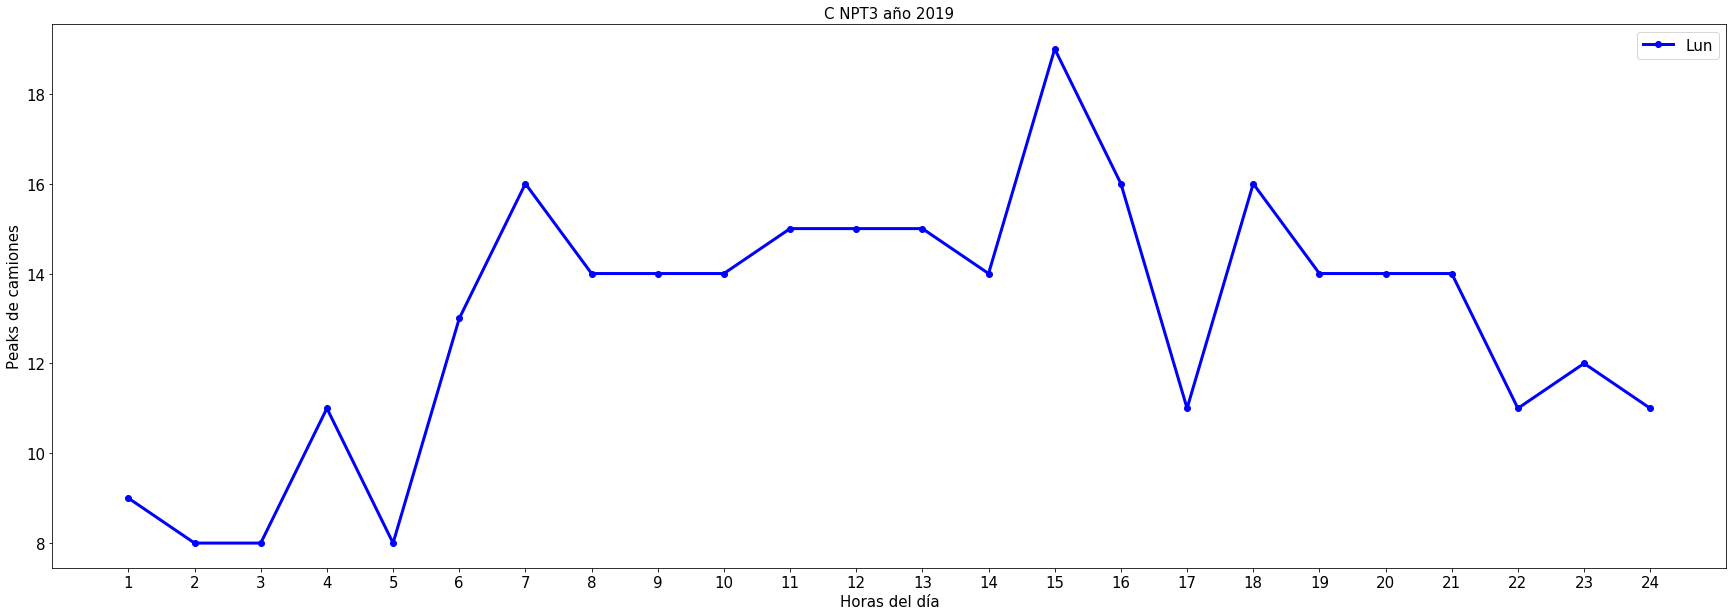

In [132]:
zona='C NPT3'
plt.figure(figsize=(30,10))
plt.plot(day_1[zona],c='b',ls='solid',lw=3,marker='o',label="Lun")
plt.legend(fontsize=15)
plt.title(zona+" año 2019",fontsize=15)
plt.xlabel("Horas del día",fontsize=15)
plt.ylabel("Peaks de camiones",fontsize=15)
plt.xticks(np.arange(1,25,1),fontsize=15)
plt.yticks(fontsize=15)
#plt.savefig("./peaks_graficos/Cumulative_day_"+i+"_peaks_out_2019.jpg")
plt.show()

In [135]:
#Cargamos los 7 dataset de 2020
day_1_ = pd.read_csv("./df_by_day/Lunes_max_out_2020.csv")
day_1_ = day_1_.set_index(np.arange(1,25,1))

day_2_ = pd.read_csv("./df_by_day/Martes_max_out_2020.csv")
day_2_ = day_2_.set_index(np.arange(1,25,1))

day_3_ = pd.read_csv("./df_by_day/Miercoles_max_out_2020.csv")
day_3_ = day_3_.set_index(np.arange(1,25,1))

day_4_ = pd.read_csv("./df_by_day/Jueves_max_out_2020.csv")
day_4_ = day_4_.set_index(np.arange(1,25,1))

day_5_ = pd.read_csv("./df_by_day/Viernes_max_out_2020.csv")
day_5_ = day_5_.set_index(np.arange(1,25,1))

day_6_ = pd.read_csv("./df_by_day/Sabado_max_out_2020.csv")
day_6_ = day_6_.set_index(np.arange(1,25,1))

day_7_ = pd.read_csv("./df_by_day/Domingo_max_out_2020.csv")
day_7_ = day_7_.set_index(np.arange(1,25,1))

In [136]:
for i in zonas:
    plt.figure(figsize=(30,10))
    plt.plot(day_1_[i],c='b',ls='solid',lw=3,marker='o',label="Lunes")
    plt.plot(day_2_[i],c='g',ls='solid',lw=3,marker='o',label="Martes")
    plt.plot(day_3_[i],c='r',ls='solid',lw=3,marker='o',label="Miercoles")
    plt.plot(day_4_[i],c='c',ls='solid',lw=3,marker='o',label="Jueves")
    plt.plot(day_5_[i],c='m',ls='solid',lw=3,marker='o',label="Viernes")
    plt.plot(day_6_[i],c='y',ls='solid',lw=3,marker='o',label="Sabado")
    plt.plot(day_7_[i],c='k',ls='solid',lw=3,marker='o',label="Domingo")
    plt.legend(fontsize=15)
    plt.title(i+" año 2020",fontsize=15)
    plt.xlabel("Horas del día",fontsize=15)
    plt.ylabel("Peaks de camiones",fontsize=15)
    plt.xticks(np.arange(1,25,1),fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig("./peaks_graficos/Cumulative_day_"+i+"_peaks_out_2020.jpg")
    plt.close()

In [137]:
day_1_tot = (day_1+day_1_)/2.
day_2_tot = (day_2+day_2_)/2.
day_3_tot = (day_3+day_3_)/2.
day_4_tot = (day_4+day_4_)/2.
day_5_tot = (day_5+day_5_)/2.
day_6_tot = (day_6+day_6_)/2.
day_7_tot = (day_7+day_7_)/2.


In [138]:
for i in zonas:
    plt.figure(figsize=(30,10))
    plt.plot(day_1_tot[i],c='b',ls='solid',lw=3,marker='o',label="Lunes")
    plt.plot(day_2_tot[i],c='g',ls='solid',lw=3,marker='o',label="Martes")
    plt.plot(day_3_tot[i],c='r',ls='solid',lw=3,marker='o',label="Miercoles")
    plt.plot(day_4_tot[i],c='c',ls='solid',lw=3,marker='o',label="Jueves")
    plt.plot(day_5_tot[i],c='m',ls='solid',lw=3,marker='o',label="Viernes")
    plt.plot(day_6_tot[i],c='y',ls='solid',lw=3,marker='o',label="Sabado")
    plt.plot(day_7_tot[i],c='k',ls='solid',lw=3,marker='o',label="Domingo")
    plt.legend(fontsize=15)
    plt.title(i+" completo",fontsize=15)
    plt.xlabel("Horas del día",fontsize=15)
    plt.ylabel("Peaks de camiones",fontsize=15)
    plt.xticks(np.arange(1,25,1),fontsize=15)
    plt.yticks(fontsize=15)
    plt.savefig("./peaks_graficos/Cumulative_day_"+i+"_peaks_out_complete.jpg")
    plt.close()

# Graficos de Mes, como Subplots

In [149]:
zone='C NPT3'
fig, axs = plt.subplots(4,3,figsize=(35,25))
fig.suptitle("Cantidad Peak de camiones saliendo de la ZO 'NPT3' por bloque horario",fontsize =30)
plt.setp(axs, xticks=np.arange(1,25,1))

axs[0,0].plot(df_1[zone],'bo--')
axs[0,0].set_title('Enero',fontsize=20)
axs[0,0].set_xticklabels(np.arange(1,25,1),fontsize=15)
axs[0,0].set_yticklabels(np.arange(1,11,1),fontsize=15)

axs[0,1].plot(df_2[zone],'bo--')
axs[0,1].set_title('Febrero',fontsize=20)
axs[0,1].set_xticklabels(np.arange(1,25,1),fontsize=15)
axs[0,2].set_yticklabels(np.arange(1,11,1),fontsize=15)

axs[0,2].plot(df_3[zone],'bo--')
axs[0,2].set_title('Marzo',fontsize=20)
axs[0,2].set_xticklabels(np.arange(1,25,1),fontsize=15)
axs[0,2].set_yticklabels(np.arange(1,11,1),fontsize=15)

axs[1,0].plot(df_4[zone],'bo--')
axs[1,0].set_title('Abril',fontsize=20)
axs[1,0].set_xticklabels(np.arange(1,25,1),fontsize=15)
axs[1,0].set_yticklabels(np.arange(1,11,1),fontsize=15)

axs[1,1].plot(df_5[zone],'bo--')
axs[1,1].set_title('Mayo',fontsize=20)
axs[1,1].set_xticklabels(np.arange(1,25,1),fontsize=15)
axs[1,1].set_yticklabels(np.arange(1,11,1),fontsize=15)

axs[1,2].plot(df_6[zone],'bo--')
axs[1,2].set_title('Junio',fontsize=20)
axs[1,2].set_xticklabels(np.arange(1,25,1),fontsize=15)
axs[1,2].set_yticklabels(np.arange(1,11,1),fontsize=15)

axs[2,0].plot(df_7[zone],'bo--')
axs[2,0].set_title('Julio',fontsize=20)
axs[2,0].set_xticklabels(np.arange(1,25,1),fontsize=15)
axs[2,0].set_yticklabels(np.arange(1,11,1),fontsize=15)

axs[2,1].plot(df_8[zone],'bo--')
axs[2,1].set_title('Agosto',fontsize=20)
axs[2,1].set_xticklabels(np.arange(1,25,1),fontsize=15)
axs[2,1].set_yticklabels(np.arange(1,11,1),fontsize=15)

axs[2,2].plot(df_9[zone],'bo--')
axs[2,2].set_title('Septiembre',fontsize=20)
axs[2,2].set_xticklabels(np.arange(1,25,1),fontsize=15)
axs[2,2].set_yticklabels(np.arange(1,11,1),fontsize=15)

axs[3,0].plot(df_10[zone],'bo--')
axs[3,0].set_title('Octubre',fontsize=20)
axs[3,0].set_xticklabels(np.arange(1,25,1),fontsize=15)
axs[3,0].set_yticklabels(np.arange(1,11,1),fontsize=15)

axs[3,1].plot(df_11[zone],'bo--')
axs[3,1].set_title('Noviembre',fontsize=20)
axs[3,1].set_xticklabels(np.arange(1,25,1),fontsize=15)
axs[3,1].set_yticklabels(np.arange(1,11,1),fontsize=15)

axs[3,2].plot(df_12[zone],'bo--')
axs[3,2].set_title('Diciembre',fontsize=20)
axs[3,2].set_xticklabels(np.arange(1,25,1),fontsize=15)
axs[3,2].set_yticklabels(np.arange(1,11,1),fontsize=15)
plt.savefig("peaks_trucks_out_NPT3.jpg")
plt.show()

In [148]:
df_3['C NPT3'].plot()

In [150]:
dias_mes = [[1,31],[32,60],[61,91],[92,121],[122,152],[153,160],[182,212],[213,243],[244,273],[274,304],[305,334],[335,365]]
#Enero
Jan = dict_to_df(vehiculos(dias_mes[0][0],dias_mes[0][1],1,25,condition="out"))
Jan_n = Jan/(dias_mes[0][1]-dias_mes[0][0]+1) 
Jan_n.to_csv("Enero_prom.csv")
print("Enero")

#Febrero
Feb = dict_to_df(vehiculos(dias_mes[1][0],dias_mes[1][1],1,25,condition="out"))
Feb_n = Feb/(dias_mes[1][1]-dias_mes[1][0]+1) 
Feb_n.to_csv("Febrero_prom.csv")
print("Febrero")

#Marzo
Mar = dict_to_df(vehiculos(dias_mes[2][0],dias_mes[2][1],1,25,condition="out"))
Mar_n = Mar/(dias_mes[2][1]-dias_mes[2][0]+1) 
Mar_n.to_csv("Marzo_prom.csv")

print("Marzo")

#Abril
Apr = dict_to_df(vehiculos(dias_mes[3][0],dias_mes[3][1],1,25,condition="out"))
Apr_n = Apr/(dias_mes[3][1]-dias_mes[3][0]+1) 
Apr_n.to_csv("Abril_prom.csv")

print("Abr")

#Mayo
May = dict_to_df(vehiculos(dias_mes[4][0],dias_mes[4][1],1,25,condition="out"))
May_n = May/(dias_mes[4][1]-dias_mes[4][0]+1) 
May_n.to_csv("Mayo_prom.csv")

print("May")

#Junio
Jun = dict_to_df(vehiculos(dias_mes[5][0],dias_mes[5][1],1,25,condition="out"))
Jun_n = Jun/(dias_mes[5][1]-dias_mes[5][0]+1) 
Jun_n.to_csv("Junio_prom.csv")
print("June")

#Julio
July = dict_to_df(vehiculos(dias_mes[6][0],dias_mes[6][1],1,25,condition="out"))
July_n = July/(dias_mes[6][1]-dias_mes[6][0]+1)  
July_n.to_csv("Julio_prom.csv")

print("July")

#Agosto
Aug = dict_to_df(vehiculos(dias_mes[7][0],dias_mes[7][1],1,25,condition="out"))
Aug_n = Aug/(dias_mes[7][1]-dias_mes[7][0]+1)  
Aug_n.to_csv("Aug_prom.csv")
print("Aug")

#Sep
Sep = dict_to_df(vehiculos(dias_mes[8][0],dias_mes[8][1],1,25,condition="out"))
Sep_n = Sep/(dias_mes[8][1]-dias_mes[8][0]+1)  
Sep_n.to_csv("Septiembre_prom.csv")
print("Sep")

#Oct
Oct = dict_to_df(vehiculos(dias_mes[9][0],dias_mes[9][1],1,25,condition="out"))
Oct_n = Oct/(dias_mes[9][1]-dias_mes[9][0]+1) 
Oct_n.to_csv("Octubre_prom.csv")
print("Oct")

#Nov
Nov = dict_to_df(vehiculos(dias_mes[10][0],dias_mes[10][1],1,25,condition="out"))
Nov_n = Nov/(dias_mes[10][1]-dias_mes[10][0]+1)  
Nov_n.to_csv("Noviembre_prom.csv")
print("Nov")

#Dec
Dec = dict_to_df(vehiculos(dias_mes[11][0],dias_mes[11][1],1,25,condition="out"))
Dec_n = Dec/(dias_mes[11][1]-dias_mes[11][0]+1) 
Dec_n.to_csv("Diciembre_prom.csv")
print("Dec")

Enero
Febrero
Marzo
Abr
May
June
July
Aug
Sep
Oct
Nov
Dec
